## SI 670 Applied Machine Learning, Week 3:  Regularization, Logistic Regression, and Evaluation (Due 09/28 11:59pm)

For this assignment, you will be exercising on questions related to linear regression, polynomial feature expansion, underfitting/overfitting, and cross-validation.

Each question is worth 20 points, for a total of 100 points. Correct answers and code receive full credit, but partial credit will be awarded if you have the right idea even if your final answers aren't quite right.

Submit your completed notebook file to the Canvas site - IMPORTANT: please name your submitted file si670-hw1-youruniqname.ipynb and be sure to put your name at the top of your notebook file. Please also make sure to upload the html version.

As a reminder, the notebook code you submit must be your own work. Feel free to discuss general approaches to the homework with classmates: if you end up forming more of a team discussion on multiple questions, please include the names of the people you worked with at the top of your notebook file.


### Put your name here: Martin Zanaj

### Put your uniquename here: mzanaj

### Preliminary
In this assignment you will train several linear classifier models and evaluate how effectively they predict instances of fraud using data based on [this dataset from Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). Then you'll perform a grid search to find optimal parameters. 
 
Each row in `fraud_data.csv` corresponds to a credit card transaction. Features include confidential variables `V1` through `V28` as well as `Amount` which is the amount of the transaction. 
 
The target is stored in the `class` column, where a value of 1 corresponds to an instance of fraud and 0 corresponds to an instance of not fraud.

In [1]:
# run this cell if you are using Jupyter
files = {'fraud_data.csv': 'fraud_data.csv'}

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split

df = pd.read_csv(files['fraud_data.csv'])

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
#Will avoid displaying warning messages against logistic's regression
import warnings
warnings.filterwarnings("ignore")

### Question 1 (20 points)

Using `X_train`, `X_test`, `y_train`, and `y_test` (as defined above), train a dummy classifier that classifies everything as the majority class of the training data. What is the accuracy of this classifier? What is the recall?

Then train a LogisticRegression classifier with C=1. What is the accuracy? What is the recall?

*This function should a return a tuple with four floats, i.e. `(dummy_accuracy, dummy_recall, lr_accuracy, lr_recall)`.*

In [4]:
def answer_one():
    from sklearn.dummy import DummyClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score,recall_score
    from sklearn.metrics import confusion_matrix
    
    #Dummy classifier
    #Negative class (0) is most frequent, frauds are less likely to happen
    dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
    y_majority_predicted = dummy_majority.predict(X_test)
    
    #Logistics Classifier
    lr = LogisticRegression(C=1).fit(X_train, y_train)
    lr_predicted = lr.predict(X_test)
        
    #Metrics
    dummy_accuracy= accuracy_score(y_test, y_majority_predicted)
    dummy_recall = recall_score(y_test, y_majority_predicted)
    
    lr_accuracy= accuracy_score(y_test, lr_predicted)
    lr_recall = recall_score(y_test, lr_predicted)
    
    
    #Double check metrics
    #Accuracy = TP + TN / (TP + TN + FP + FN)
    #Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
    confusion_d = confusion_matrix(y_test, y_majority_predicted)
    confusion_l = confusion_matrix(y_test, lr_predicted)
    
    return dummy_accuracy, dummy_recall, lr_accuracy, lr_recall

answer_one()

(0.9983146540827504, 0.0, 0.9990871042948232, 0.6)

### Question 2 (20 points)

Fit the LogisticRegression with `C` varying from `[[0.1, 1, 10]` and report the accuracy, precision, recall, and F1 scores for each choice of `C`.

*This function should a return a tuple with four lists, i.e. `(accuracy_list, precision_list, recall_list, f1_list)`, and each list should contain 3 numbers.*

In [5]:
def answer_two():
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import confusion_matrix
    
    #Logistics regression for different  C levels
    C= [0.1,1,10]
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    
    for c_level in C:
        #Model, prediction
        logr = LogisticRegression(C=c_level).fit(X_train, y_train)
        logr_pred = logr.predict(X_test)
        
        #Metrics
        accuracy_list.append(accuracy_score(y_test, logr_pred))
        precision_list.append(precision_score(y_test, logr_pred))
        recall_list.append(recall_score(y_test, logr_pred))
        f1_list.append(f1_score(y_test, logr_pred))
        #print(confusion_matrix(y_test, logr_pred))

    return accuracy_list, precision_list, recall_list, f1_list

answer_two()

([0.9990871042948232, 0.9990871042948232, 0.9990871042948232],
 [0.8089887640449438, 0.8089887640449438, 0.8089887640449438],
 [0.6, 0.6, 0.6],
 [0.6889952153110048, 0.6889952153110048, 0.6889952153110048])

### Question 3 (20 points)

Train a logistic regression classifier with `C=10` using X_train and y_train.

For the logistic regression classifier, create (1) a precision-recall curve and (2) a roc curve using y_test and the probability estimates for X_test (probability it is fraud).

Looking at the precision recall curve, what is the recall when the precision is `0.75`?

Looking at the ROC curve, what is the true positive rate when the false positive rate is `0.16`?

*This function should return a tuple with two floats, i.e. `(recall_at_p75, tpr_at_fpr16)`.*
*You should also includce code to generate the precision/recall and ROC curves above*

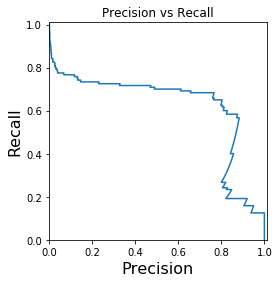

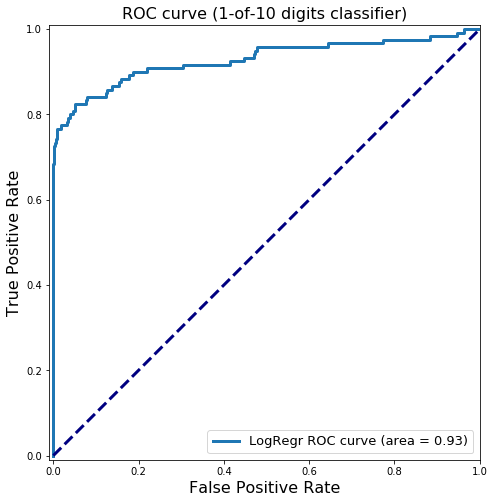

(0.7, 0.75)

In [6]:
def answer_three():
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    
    #Model, prediction
    logr = LogisticRegression(C=10).fit(X_train, y_train)
    logr_pred = logr.predict(X_test)    
    y_score = logr.decision_function(X_test)

    #Precision Recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    
    #Precision Recall graph
    plt.figure()
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.plot(precision, recall, label='Precision-Recall Curve')
    
    plt.xlabel('Precision', fontsize=16)
    plt.ylabel('Recall', fontsize=16)
    plt.title('Precision vs Recall')
    plt.axes().set_aspect('equal')
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, y_score)  
    roc_auc = auc(fpr, tpr) 
    
    plt.figure(figsize=(8, 8))
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()
    
    #These are approximations from looking at the graph
    recall_at_p75 = 0.70
    tpr_at_fpr16 = 0.75
    
    return recall_at_p75, tpr_at_fpr16

answer_three()

## Question 4 (20 Points)

Suppose you have trained a classifier distinguishing Benign vs Malignant cancers. And the confusion matrix of your classifier is given below.

|      	| Predicted: Benign 	| Predicted: Malignant 	|
|:----:	|----	|----	|
| Actual: Benign 	|    10000	|   100 	|
| Actual: Malignant  	|    200	|   10 	|

### Question (a) (10 points) 
If we assume Benign is the positive class and Malignant is the negative class, what are the precision and recall for Benign? If we assume Malignant is the positive class and Benign is the negative class, what are the precision and recall for Malignant?

*This function should return a tuple of four float numbers: `(precision_benign, recall_genign, precision_maligant, recall_maligant)`. You can calculate these scores either by coding or by hands.*

In [7]:
def answer_four_a():
    
    #Benign ==1 , Malign==0
    #Precision, TP/ TP+FP
    precision_benign = 10000/ (10000+200)
    #Recall, TP/TP+FN
    recall_genign = 10000/ (10000+100)
       
    #Malign==1 , Benign ==0
    #Precision, TP/ TP+FP
    precision_maligant = 10/ (10+ 100)
    #Recall, TP/TP+FN
    recall_maligant =  10/ (10+200)
    
    #Fscores
    f_score1= 2* (precision_benign*recall_genign)/ (precision_benign+recall_genign)
    f_score2= 2* (precision_maligant*recall_maligant)/ (precision_maligant+recall_maligant)
    
#     print("F1: ", f_score1)
#     print("F2: ", f_score2)
    return precision_benign, recall_genign, precision_maligant, recall_maligant

answer_four_a()

(0.9803921568627451,
 0.9900990099009901,
 0.09090909090909091,
 0.047619047619047616)

### Question (b) (10 points) 
If you have another classifier with the following confusion matrix, which classifier do you prefer and why? (Hint: calculate the precision and recall scores for this classifier and compare with the previous classifier.)

|      	| Predicted: Benign 	| Predicted: Malignant 	|
|:----:	|----	|----	|
| Actual: Benign 	|    7000	|   3100 	|
| Actual: Malignant  	|    30	|   180 	|


In [40]:
#Benign ==1 , Malign==0
#Precision, TP/ TP+FP
precision_benign = 7000/ (7000+30)
#Recall, TP/TP+FN
recall_genign = 7000/ (7000+3100)
       
#Malign==1 , Benign ==0
#Precision, TP/ TP+FP
precision_maligant = 3100/ (3100+ 180)
#Recall, TP/TP+FN
recall_maligant =  3100/ (3100+30)
print(precision_benign, recall_genign, precision_maligant, recall_maligant)

f_score11= 2* (precision_benign*recall_genign)/ (precision_benign+recall_genign)
f_score22= 2* (precision_maligant*recall_maligant)/ (precision_maligant+recall_maligant)
   
print("F1: ", f_score11)
print("F2: ", f_score22)

0.9957325746799431 0.693069306930693 0.9451219512195121 0.9904153354632588
F1:  0.8172796263864565
F2:  0.967238689547582


#### Answer to quesiton 4 (b)

>In the **first model** case 1 has high precision & high recall (.98,.99), but in the second case we have poor precision & poor reacall (0.09, 0.04). In the **second model** case 1 has high precision & low recall (.99,.69), and in the second case we have high precision & high reacall (0.94, 0.99).

>At first it might not be apparent which model  is the best, and that is why computing the F1 score can help with the final evaluation. 

     Fscore model 1
        - Case 1: 0.98
        - Case 2: 0.06
        
     Fscore model 2
        - Case 1: 0.82
        - Case 2: 0.97

>In conclusion, I would suggest that *model 2* has a better overall performance given that is has a more balanced ratio between precision & recall(FP, FN). Altough, this is preferedd, one must as well consider the *domain of application* and willing to make tradeoffs between the two competing forces of precision & recall. 

## Question 5 (20 Points)

Now, we will compare the performance of Ridge, Lasso and OLS perform on the dataset where the relationship between X and y is non-linear.

Let's start by generating some data using the function below. 


In [8]:
import numpy as np

def generate_data(n_samples, n_features, noise=0.0, random_state=670):
    assert n_features > 1
    rs = np.random.RandomState(random_state)
    X = rs.uniform(size=(n_samples, n_features))
    y = 3 * np.sin(2*np.pi * X[:, 0]) + 6.7 * X[:, 1] + 10 * np.power(X[:, 2], 3) + noise * rs.normal(size=(n_samples,))
    return X, y
X, y = generate_data(n_samples = 200, n_features=10, noise=1, random_state=670)

### Question 5 (a) Feature expansion (5 points)
First, we are going use sklearn.preprocessing.PolynomialFeatures with `degree = 3`  to expand the feature (Remeber we did that in Lab 2!) 

*This function should return `X_poly`, which is the new feature set after feature expansion.*

In [9]:
from sklearn.preprocessing import PolynomialFeatures
def answer_five_expansion():
    # Polynomial expansion
    poly = PolynomialFeatures(degree= 3)
    X_poly = poly.fit_transform(X)
    return X_poly
answer_five_expansion()


array([[1.00000000e+00, 5.68227393e-02, 2.27414107e-02, ...,
        2.35360618e-02, 4.68318550e-02, 9.31856257e-02],
       [1.00000000e+00, 9.05263188e-01, 9.24187355e-01, ...,
        4.14924001e-01, 2.41676170e-01, 1.40766431e-01],
       [1.00000000e+00, 6.50709351e-01, 1.28597300e-01, ...,
        1.59759055e-02, 2.22254166e-02, 3.09196333e-02],
       ...,
       [1.00000000e+00, 8.93692785e-01, 4.15921030e-01, ...,
        3.76747976e-02, 6.24732846e-02, 1.03594751e-01],
       [1.00000000e+00, 3.99743480e-01, 8.59403360e-01, ...,
        2.18379718e-03, 1.79022498e-03, 1.46758385e-03],
       [1.00000000e+00, 2.03035027e-01, 1.87128496e-01, ...,
        1.68814391e-04, 1.09333436e-03, 7.08103150e-03]])

### Question 5 (b) Split and Standardize (5 points)
Then, use the `sklearn.preprocessing.StandardScaler` to normalize the feature `X_poly` and split the training and testing data with `train_size = 0.8` and `random_state = 670`. 

*This function should return the standardized dataset, `standardized_X_poly_train, standardized_X_poly_test, y_poly_train, y_poly_test`.*

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def answer_five_split_standardize():
    X_poly = answer_five_expansion()
    
    #Train/Test Dataset
    X_train, X_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, random_state=670, train_size= .80)
    
    #Standardize/normalize the data (mean=0, sd=1)
    scaler = StandardScaler()
    
    standardized_X_poly_train = scaler.fit_transform(X_train)
    standardized_X_poly_test = scaler.fit_transform(X_test)
    
    return standardized_X_poly_train, standardized_X_poly_test, y_poly_train, y_poly_test
answer_five_split_standardize()

(array([[ 0.        ,  1.52443361,  1.13127464, ..., -0.75901895,
         -0.67388025, -0.62659948],
        [ 0.        , -0.76923476,  0.8787083 , ..., -0.12284315,
         -0.57675353, -0.80395527],
        [ 0.        ,  0.14637105, -0.39850109, ...,  1.50628647,
          0.35722254, -0.44911109],
        ...,
        [ 0.        ,  1.22898015,  0.08764707, ..., -0.79435078,
         -0.76681621, -0.79385361],
        [ 0.        , -0.31888116,  1.12614288, ..., -0.81659096,
         -0.79633825,  0.11136322],
        [ 0.        ,  1.00109535,  1.12274753, ...,  0.07180839,
          0.59892653,  0.70377897]]),
 array([[ 0.        ,  1.04609853, -0.55001307, ..., -0.89255471,
         -0.83366274,  0.2283439 ],
        [ 0.        , -0.53431493, -0.29429849, ..., -0.8764151 ,
         -0.65582463,  0.6597581 ],
        [ 0.        , -1.5897467 , -0.81312309, ...,  0.46146557,
         -0.35623492, -0.8063101 ],
        ...,
        [ 0.        , -0.63619274, -1.28096832, ..., -

### Question 5 (c-1) Model comparison (2 points)
If we train different linear models, i.e., Linear Regression, Ridge, and Lasso, with the pre-processed training set (standardized_X_poly_train, y_poly_train), which model do you expect to generate the best performance on the testing set and why?

#### Answer to Question 5 (c-1)
Our predictor space is fairly large, and as a result I aspect linear regression (ols) to overfit the training data given that it might perceive the high **random noise** contamination as something real. As a result of this overfit, it will yield a high performance (smalle RSE). The other two methods, Lasso & Ridge, are still in part OLS, but do have some regularization parameters that can aid against overfitting. Finally, I do aspect Lasso to be the best model on the TESTING data, given that it can act as a model/feature selection as it pushes insignificant coefficients to ZERO.

### Question 5 (c-2) Model comparison and model selection (8 points)
Next, let's see which model indeed performs better on our dataset. In this function, you will:
* Train a Linear Regression model (with default settings), and print the training and testing R-squared scores;
* Train a Ridge model for each alpha in the `alpha_list`, select the Ridge model that generates the highest R-squared score on the training set, print both the training and testing R-squared scores of the best-performing Ridge model (i.e., the model with the alpha that generates the highest R-squared score);
* Train a Lasso model for each alpha in the `alpha_list`, select the Lasso model that generates the highest R-squared score on the training set, print both the training and testing R-squared scores of the best-performing Lasso model (i.e., the Lasso model with the alpha that generates the highest R-squared score);
* Return the the training and testing R-squared scores of the Linear Regression model, the best-performing Ridge model, and the best-performing Lasso model: `linreg_r_2_train, linreg_r_2_test, best_ridgereg_r_2_train, best_ridgereg_r_2_test, best_lassoreg_r_2_train, best_lassoreg_r_2_test)`.

In [11]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression

def answer_five_compare():
    
    standardized_X_poly_train, standardized_X_poly_test, y_poly_train, y_poly_test = answer_five_split_standardize()
    
    alpha_list = [0.01, 0.1, 1, 2, 3, 5, 10, 50, 100, 200]
        
    # -------------------- Linear Regression ----------------
    linreg= LinearRegression().fit(standardized_X_poly_train,y_poly_train)
    linreg_r_2_train = linreg.score(standardized_X_poly_train, y_poly_train)
    linreg_r_2_test = linreg.score(standardized_X_poly_test, y_poly_test)
    
    print('R-squared score of Linear Regression (train): {:.3f}'.format(linreg_r_2_train))    
    print('R-squared score of Linear Regression (test): {:.3f}'.format(linreg_r_2_test))      
    
    
    # -------------------- Ridge ---------------------------
    r2_train_ridge = []
    r2_test_ridge = []
    for alpha in alpha_list:
        linridge = Ridge(alpha = alpha)
        linridge.fit(standardized_X_poly_train, y_poly_train)
        r2_train_ridge.append(linridge.score(standardized_X_poly_train, y_poly_train))
        r2_test_ridge.append(linridge.score(standardized_X_poly_test, y_poly_test))
    
    best_ridgereg_r_2_train = max(r2_train_ridge)
    index= r2_train_ridge.index(max(r2_train_ridge))
    best_ridgereg_r_2_test = r2_test_ridge[index]
    
    print('R-squared score of Ridge Regression (train): {:.3f}'.format(best_ridgereg_r_2_train))
    print('R-squared score of Ridge Regression (test): {:.3f}'.format(best_ridgereg_r_2_test))
        
    # -------------------- Lasso ---------------------------
    r2_train_lasso = []
    r2_test_lasso = []
    for alpha in alpha_list:
        linlasso = Lasso(alpha).fit(standardized_X_poly_train, y_poly_train)
        r2_train_lasso.append(linlasso.score(standardized_X_poly_train, y_poly_train))
        r2_test_lasso.append(linlasso.score(standardized_X_poly_test, y_poly_test))
        
    best_lassoreg_r_2_train = max(r2_train_lasso)
    index= r2_train_lasso.index(max(r2_train_lasso))
    best_lassoreg_r_2_test = r2_test_lasso[index]
    
        
    print('R-squared score of Lasso Regression (train): {:.3f}'.format(best_lassoreg_r_2_train))
    print('R-squared score of Lasso Regression (test): {:.3f}'.format(best_lassoreg_r_2_test))
    
    
    return (linreg_r_2_train, linreg_r_2_test, best_ridgereg_r_2_train, best_ridgereg_r_2_test, 
            best_lassoreg_r_2_train, best_lassoreg_r_2_test)
answer_five_compare()

R-squared score of Linear Regression (train): 1.000
R-squared score of Linear Regression (test): 0.104
R-squared score of Ridge Regression (train): 1.000
R-squared score of Ridge Regression (test): 0.156
R-squared score of Lasso Regression (train): 0.961
R-squared score of Lasso Regression (test): 0.617


(1.0,
 0.10400006881135115,
 0.9999539315772671,
 0.15590690938809149,
 0.9612569688756333,
 0.6167402758942504)